# Estimation on real data using MSM

In [1]:
from consav import runtools
runtools.write_numba_config(disable=0,threads=4)

%matplotlib inline
%load_ext autoreload
%autoreload 2

# Local modules
from Model import RetirementClass
import figs
import SimulatedMinimumDistance as SMD

# Global modules
import numpy as np
import matplotlib.pyplot as plt

# Singles

In [235]:
shape = (11,8)

In [236]:
moments = pd.read_excel('SASdata/single_moments.xlsx')
mom_data = moments['Moments'].to_numpy()
mm = mom_data.reshape(shape)
mom_se = moments['SE'].to_numpy()
weight = SMD.weight_matrix_single(mom_se,shape)
ww = np.diag(weight).reshape(shape)

Weight matrix

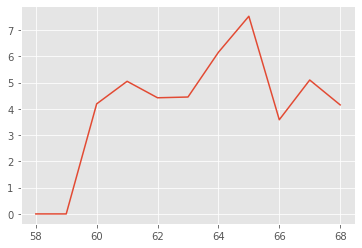

In [237]:
plt.plot(np.arange(58,69),np.mean(ww,axis=1))

Moments

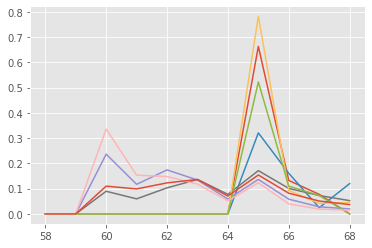

In [239]:
plt.plot(np.arange(58,69),mm)
plt.show()

### Set up estimation

In [214]:
Single = RetirementClass(simN=int(1e5), simT=68-57+1)
Single.solve()
Single.simulate()

In [215]:
# function to generate moments
def mom_fun(sim):
    return SMD.MomFunSingle(sim,Single.par)

In [216]:
add_str = '_est'
est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta")
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', 
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Single,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [6]:
theta0 = SMD.start(10,bounds=[(0.0,1.0), (0.0,1.0), (0.1,0.8), (-1.0,1.0)])

In [10]:
smd.MultiStart(theta0,weight)
theta = smd.est
#theta = np.array([0.48704889, 0.50153614, -0.16117956, 0.267018 ])

### Results

In [14]:
Nobs = 500
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Single.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
SMD.save_est(est_par,theta,name='Single') # save parameters

Parameters: [ 0.487  0.502 -0.161  0.267]
Std error : [0.0005 0.0012 0.0002 0.0003]


### Model fit

In [ ]:
smd.obj_fun(theta,weight) # set theta as parameters

In [ ]:
def mom_data_total(MA):
    data = pd.read_excel('SASdata/single_moments_total.xlsx')
    mom = np.reshape(data['Moments'].to_numpy(), newshape=(int(len(data)/3),3), order='F')
    if len(MA)>1:
        return mom[:,-1]
    else:
        return mom[:,MA[0]]
    
def model_fit(MA):
    G_data = {'y': [mom_data_total(MA=MA)], 'x': np.arange(58,69), 'label': ['Data'], 'color': 'k', 
              'linestyle': ['None'], 'marker': 'o'}
    G_pred = figs.retirement_probs(Single,MA=MA)
    return [G_data,G_pred]

Women

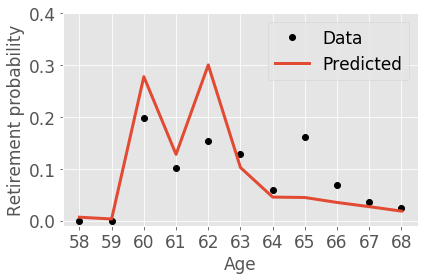

In [17]:
figs.MyPlot(model_fit([0]),ylim=[-0.01,0.4],linewidth=3,save=True).savefig('figs/ModelFit/SingleWomen.png')

Men

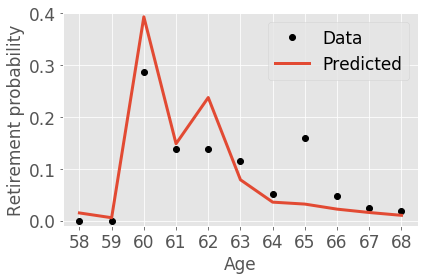

In [18]:
figs.MyPlot(model_fit([1]),ylim=[-0.01,0.4],linewidth=3,save=True).savefig('figs/ModelFit/SingleMen.png')

### Sensitivity to first step calibrated parameters

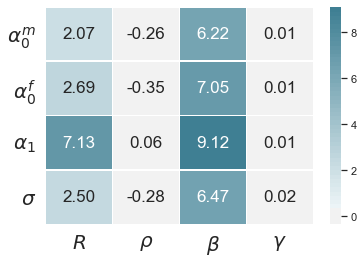

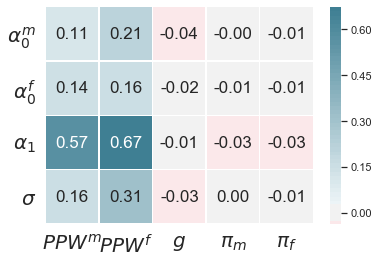

In [230]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:4],smd.sens2e[:,:4],theta,est_par_tex,fixed_par_tex[:4]).savefig('figs/Sens/SinglePref.png')
figs.sens_fig_tab(smd.sens2[:,4:],smd.sens2e[:,4:],theta,est_par_tex,fixed_par_tex[4:]).savefig('figs/Sens/SingleCali.png')

### Clean up (to save memory)

In [ ]:
del Single

# Couples

In [2]:
shape = (2,11,9+16)

In [3]:
moments = pd.read_excel('SASdata/couple_moments.xlsx',skip_blank_lines=False)
mom_data = np.concatenate((moments['Moments_H'].to_numpy(),moments['Moments_W'].to_numpy()))
mm = mom_data.reshape(shape)
mom_data[np.isnan(mom_data)] = 0
mom_se = np.concatenate((moments['SE_H'].to_numpy(),moments['SE_W'].to_numpy()))
weight = SMD.weight_matrix_couple(mom_se,shape,factor=[1/5,1/5,1,1,1,1,1,1,1,1,1]) # factor rescales the time periods
ww = np.diag(weight).reshape(shape)

Weight matrix

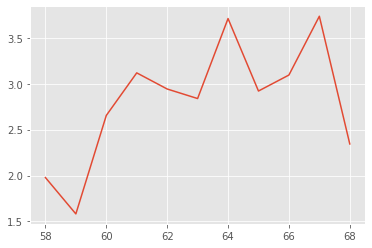

In [4]:
plt.plot(np.arange(58,69),np.mean(ww,axis=(0,2)))

Moments - Women

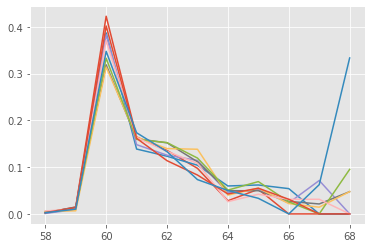

In [5]:
plt.plot(np.arange(58,69), mm[1,:,:9])
plt.show()

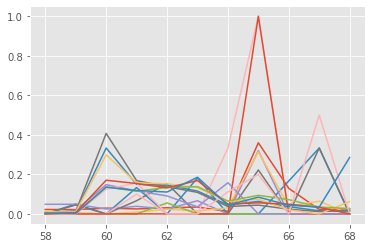

In [6]:
plt.plot(np.arange(58,69), mm[1,:,9:])
plt.show()

Moments - Men

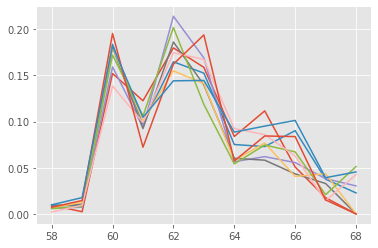

In [7]:
plt.plot(np.arange(58,69), mm[0,:,:9])
plt.show()

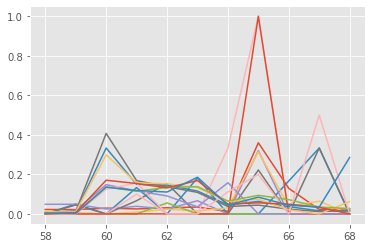

In [8]:
plt.plot(np.arange(58,69), mm[1,:,9:])
plt.show()

### Set up estimation

In [ ]:
Couple = RetirementClass(couple=True, simN=int(1e5), simT=68-53+1)
Couple.solve()
Couple.simulate()

In [ ]:
# function to generate moments
def mom_fun(sim):
    return SMD.MomFunCouple(Couple)

In [ ]:
add_str = '_est'
est_par = ("alpha_0_male", "alpha_0_female", "alpha_1", "sigma_eta", "phi_0", "phi_1")
est_par_tex = (r'$\alpha_0^m$', r'$\alpha_0^f$', r'$\alpha_1$', r'$\sigma$', r'$\phi_0$', r'$\phi_1$')
fixed_par = ('R', 'rho', 'beta', 'gamma', 'v',
             'priv_pension_male', 'priv_pension_female', 'g_adjust', 'pi_adjust_m', 'pi_adjust_f')
fixed_par_tex = (r'$R$', r'$\rho$', r'$\beta$', r'$\gamma$', r'$v$', 
                 r'$PPW^m$', r'$PPW^f$', r'$g$', r'$\pi_m$', r'$\pi_f$')

# Setup estimation
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par

### Estimate

In [ ]:
theta0 = SMD.start(10,bounds=[(0.0,1.0),(0.0,1.0),(-1.0,1.0),(0.2,0.8),(0.5,2.0),(-1.0,1.0)])

In [ ]:
smd.print_iter = [True,20] # print every 100 function eval
smd.MultiStart(theta0,weight)
theta = smd.est
#theta = np.array([1.0749, 0.0881, 0.0642, 1.0254, 0.3146, 0.6784, -0.4084])

In [ ]:
Nobs = 500
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
#SMD.save_est(est_par,theta,name='Couple',couple=True) # save parameters

### Estimate (phi=0)

In [223]:
Couple.par.phi_0 = 0
Couple.par.phi_1 = 0
smd = SMD.SimulatedMinimumDistance(Couple,mom_data,mom_fun)
smd.est_par = est_par[0:4]

In [243]:
theta0 = SMD.start(10,bounds=[(0.0,1.0),(0.0,1.0),(-1.0,1.0),(0.2,0.8)])

In [242]:
#smd.print_iter = [True,100] # print every 100 function eval
smd.MultiStart(theta0,weight)
theta = smd.est
#theta = np.array([1.29027932, 0.19332904, -0.05296922, 0.83587617])

### Results

In [61]:
Nobs = 500
smd.std_error(theta,weight,Nobs=Nobs,Nsim=Couple.par.simN/Nobs)
std_error = smd.std
print('Parameters:', np.round(theta,3))
print('Std error :', np.round(std_error,4))
#SMD.save_est(est_par,theta,name='RestCouple',couple=True) # save parameters

Parameters: [ 1.075  0.088  0.064  1.025  0.315  0.678 -0.408]
Std error : [0.0002 0.0002 0.003  0.0012 0.0001 0.0021 0.0009]


### Model fit

In [253]:
theta = list(SMD.load_est(name='Couple',couple=True)[0].values())
smd.obj_fun(theta,weight) # set theta as parameters

[0.4, 0.4, 0.053, 0.435, 1.187, 1.671, -0.621]

In [211]:
def model_fit_ad(ma,ad):
    moments = pd.read_excel('SASdata/couple_moments.xlsx',skip_blank_lines=False)
    mom_data = np.concatenate((moments['Moments_H'].to_numpy(),moments['Moments_W'].to_numpy())).reshape(2,11,25)
    G_data = {'y': [mom_data[-ma+1,:,ad+4]], 'x': np.arange(58,69), 'label': ['Data (ad='+str(ad)+')'], 'color': 'k',
              'linestyle': ['None'], 'marker': 'o'}
    G_pred = figs.retirement_probs_c(Couple,ma,AD=[ad])
    if ma == 1:
        G_pred['ylabel'] = None
    return [G_data,G_pred]

Women

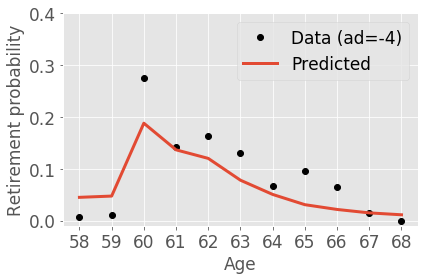

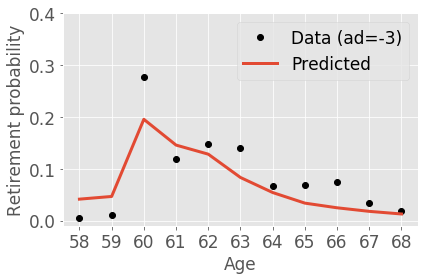

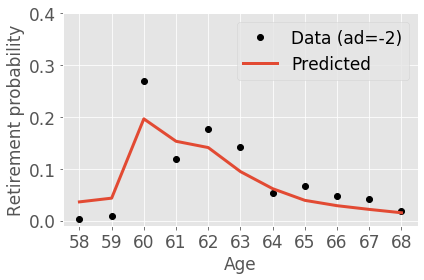

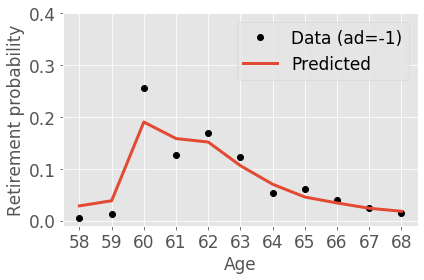

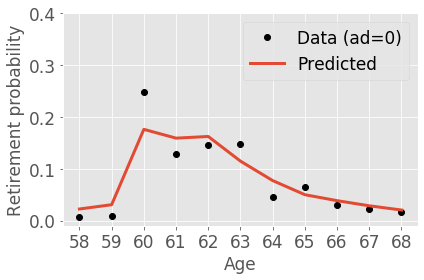

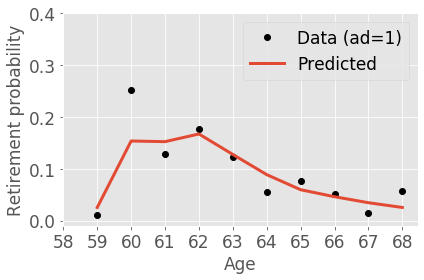

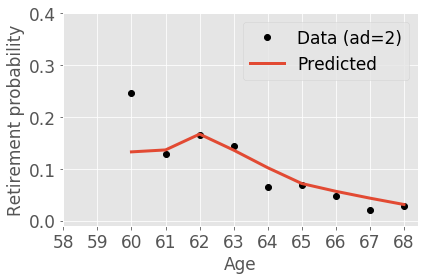

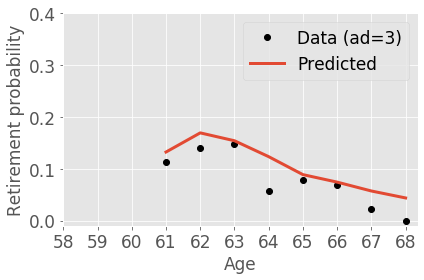

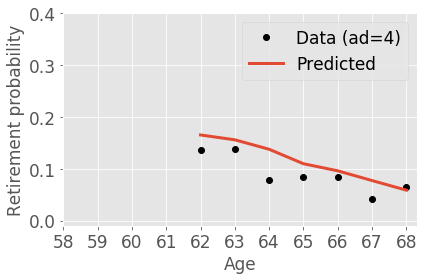

In [212]:
for ad in range(-4,4+1):
    figs.MyPlot(model_fit_ad(0,ad),linewidth=3,ylim=[-0.01,0.4]).savefig('figs/ModelFit/CoupleWomenAD_'+str(ad)+'.png')

Men

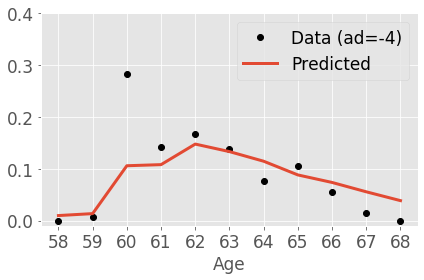

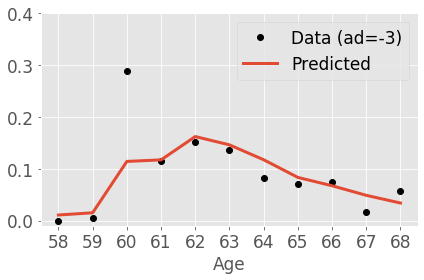

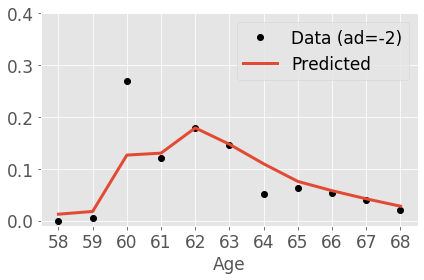

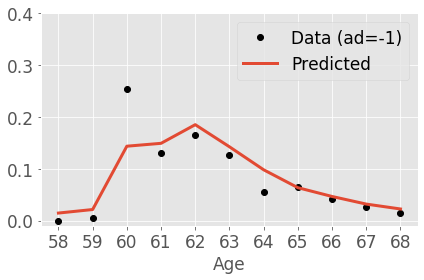

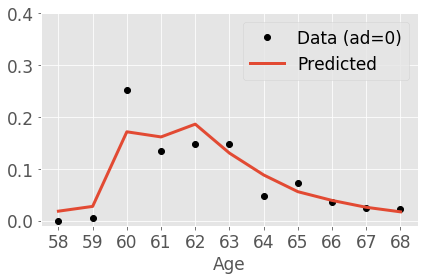

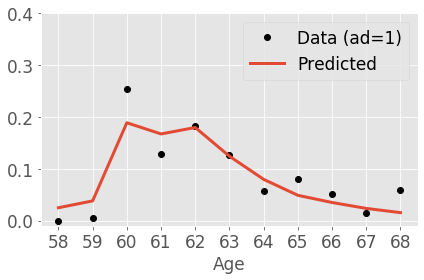

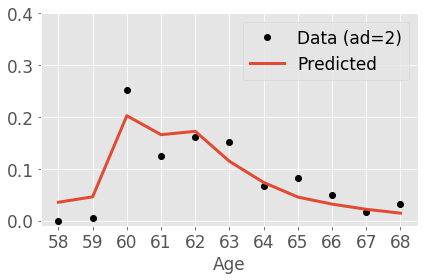

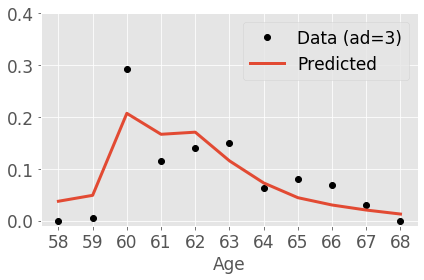

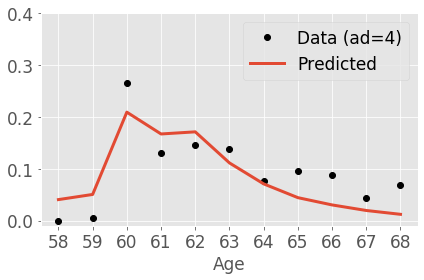

In [213]:
for ad in range(-4,4+1):
    figs.MyPlot(model_fit_ad(1,ad),linewidth=3,ylim=[-0.01,0.4]).savefig('figs/ModelFit/CoupleMenAD_'+str(ad)+'.png')

### Sensitivity to first step calibrated parameters

In [ ]:
smd.recompute=True
smd.sensitivity(theta,weight,fixed_par)
figs.sens_fig_tab(smd.sens2[:,:5],smd.sens2e[:,:5],theta,est_par_tex,fixed_par_tex[:5]).savefig('figs/Sens/CouplePref.png')
figs.sens_fig_tab(smd.sens2[:,5:],smd.sens2e[:,5:],theta,est_par_tex,fixed_par_tex[5:]).savefig('figs/Sens/CoupleCali.png')